# Alveoli and acinar size
This document is used to plot the acinar volumes and stereological counts for the alveolar manuscript.

In [1]:
# Assess coding style, based on https://stackoverflow.com/a/47204361/323100

# %load_ext pycodestyle_magic
# and then put '%%pycodestyle' in the cells

# Or do it like so from the Terminal:
# jupyter nbconvert Acinar\ and\ alveolar\ number.ipynb --to script  && pycodestyle *.py --ignore=E501,E402,W391 --show-source

First, we set up the notebook.

In [19]:
# Load the data and set up notebook
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import glob
import os
import pandas
import seaborn
import timeit
import numpy

In [20]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [21]:
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook'
      % the_current_git_hash)

We are working with version abbb2f3 of the analyis notebook


In [22]:
# Display defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.transparent'] = True  # Save figures with transparent background

In [23]:
# Make us an output folder (including the git hash, so we (potentially) have different versions of the images)
imgdir = os.path.join('img', the_current_git_hash)
os.makedirs(imgdir, exist_ok=True)

Now we load the 'Count' data from Eveline.

In [24]:
# # Different locations if running either on Linux or Windows
# if 'debian' in platform.dist():
#     drive = os.path.join(os.sep, 'home', 'habi', 'nas_gruppe_schittny')
# else:
#     drive = os.path.join('\\\\nas.ana.unibe.ch\\', 'gruppe_schittny', 'Data')
# # Load the data from this folder
# RootPath = os.path.join(drive, 'doc', 'David')
# print('We are loading all the data from %s' % RootPath)

In [25]:
# We copied everything from nas_schittny and the terastation to 'fast SSD'.
# Load the data from there
if 'debian' in platform.dist():
    drive = '/media/habi/Fast_SSD/'
else:
    drive = 'F:/'
# Load the data from this folder
RootPath = drive + os.path.join('Acini')
print('We are loading all the data from %s' % RootPath)

We are loading all the data from F:/Acini


In [26]:
# Get a list of *all* excel files that Eveline exported from the STEPanizer
# Based on https://stackoverflow.com/a/14798263
StepanizerFiles_Eveline = sorted(glob.glob(os.path.join(RootPath, '**/*201[1234567]*.xls'), recursive=True))

In [27]:
print('Eveline counted the alveoli in %s acini' % len(StepanizerFiles_Eveline))

Eveline counted the alveoli in 287 acini


In [28]:
# # Grab relevant data from filenames
# for f in StepanizerFiles_Eveline:
#     print('Animal', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3])
#     print('Day', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2])
#     print('Acinus', os.path.basename(f).split('acinus')[1].split('_')[0])

In [29]:
# Generate dataframe to save Evelines assessment
Eveline = pandas.DataFrame({'Location': StepanizerFiles_Eveline})
Eveline['Filename'] = [os.path.basename(f) for f in StepanizerFiles_Eveline]
Eveline['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_Eveline]
Eveline['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_Eveline]
Eveline['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_Eveline]
Eveline['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_Eveline]
Eveline['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_Eveline]
Eveline['Counts'] = [int(pandas.read_csv(f, nrows=13, delimiter='\t')['Total'][10]) for f in StepanizerFiles_Eveline]
# Since we seem to have different tab-count in the files, we just read one single cell, explicitly...
Eveline['Pixelsize'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                              skiprows=16, header=None, usecols=[0, 1], nrows=1)[1][0])
                        for f in StepanizerFiles_Eveline]
# Count the images in their respective folders
Eveline['Number of images'] = [[int(os.path.basename(i).split('_')[-2]) for
                                i in glob.glob(os.path.join(os.path.dirname(location),
                                                            '*.jpg'))] for
                               location in Eveline.Location]
Eveline['Number of images'] = [max(li) for li in Eveline['Number of images']]

In [30]:
Eveline.groupby(by=['Day', 'Animal'])['Counts'].describe()

count        mean         std    min     25%    50%     75%    max
Day Animal                                                                    
4   04A      50.0   27.040000   23.687558    4.0   11.25   17.5   35.00  111.0
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00  171.0
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00  249.0
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00  245.0
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25  199.0
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00  505.0
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00  781.0
    21D      17.0  196.000000  128.564672   50.0   97.00  167.0  271.00  493.0
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50  572.0
60  60B      24.0  350.875000  115.473058  161.0  253.25  364.0  424.50  648.0
    60C      20.0  103.800000   60.113577   30.0   68.00   86.0  127.00  270.0
    60D      10.0  363.700000   99.473112  222.0  299.25  368.5  390.00  591.0
    60E       9.0  395.777778  134.458895  136.0  368.00  370.0  472.00  602.0

In [31]:
# Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 3)].head()

In [32]:
# Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 4)].head()

In [33]:
# For D60, Eveline counted only half of the images, we thus double the 'counts'
Eveline.loc[Eveline.Animal == '60B', 'Counts'] = 2 * Eveline['Counts']
# For Animal 60C she counted *every* image, we thus don't double there!
Eveline.loc[Eveline.Animal == '60D', 'Counts'] = 2 * Eveline['Counts']
Eveline.loc[Eveline.Animal == '60E', 'Counts'] = 2 * Eveline['Counts']
# For two acini (acinus 3 for 60D and acinus 12 for 60E) Eveline counted every image
Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 3), 'Counts'] = 0.5 * Eveline['Counts']
Eveline.loc[(Eveline.Animal == '60E') & (Eveline.Acinus == 12), 'Counts'] = 0.5 * Eveline['Counts']
# The 'number of images' (read below) stays the same, since Eveline just skipped the images in STEPanizer!

In [34]:
# Eveline.loc[(Eveline.Animal == '60D') & (Eveline.Acinus == 4)].head()

In [35]:
# Eveline.loc[(Eveline.Animal == '60E')]

In [36]:
Eveline.groupby(by=['Day', 'Animal'])['Counts'].describe()

count        mean         std    min     25%    50%     75%  \
Day Animal                                                                
4   04A      50.0   27.040000   23.687558    4.0   11.25   17.5   35.00   
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00   
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00   
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00   
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25   
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00   
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00   
    21D      17.0  196.000000  128.564672   50.0   97.00  167.0  271.00   
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50   
60  60B      24.0  701.750000  230.946116  322.0  506.50  728.0  849.00   
    60C      20.0  103.800000   60.113577   30.0   68.00   86.0  127.00   
    60D      10.0  668.300000  121.669909  444.0  569.25  722.0  747.00   
    60E       9.0  739.111111  281.215418  272.0  640.00  738.0  770.00   

               max  
Day Animal          
4   04A      111.0  
    04B      171.0  
    04C      249.0  
10  10A      245.0  
    10B      199.0  
    10C      505.0  
21  21B      781.0  
    21D      493.0  
    21E      572.0  
60  60B     1296.0  
    60C      270.0  
    60D      810.0  
    60E     1204.0

In [37]:
# Describe counts
for d in sorted(Eveline.Day.unique()):
    print('Details of day %s' % d)
    print(Eveline.loc[Eveline.Day == d].groupby(by=['Day', 'Animal'])['Counts'].describe())
    print(80 * '-')

Details of day 4
            count       mean        std   min    25%   50%   75%    max
Day Animal                                                             
4   04A      50.0  27.040000  23.687558   4.0  11.25  17.5  35.0  111.0
    04B      23.0  65.043478  43.849410  15.0  34.50  53.0  80.0  171.0
    04C      51.0  60.509804  45.424387  10.0  29.50  52.0  77.0  249.0
--------------------------------------------------------------------------------
Details of day 10
            count        mean         std   min   25%   50%     75%    max
Day Animal                                                                
10  10A      27.0   77.851852   56.305283  18.0  28.5  69.0  122.00  245.0
    10B      14.0   84.571429   65.752115  23.0  37.5  52.0  135.25  199.0
    10C      17.0  108.764706  125.449955  15.0  46.0  73.0  105.00  505.0
--------------------------------------------------------------------------------
Details of day 21
            count        mean         std    min  

In [38]:
# What's the mean count for the days?
for d in sorted(Eveline.Day.unique()):
    print('The mean count (alveolar number) at day %02s is %6.2f (+- %6.2f STD)' % (d,
                                                                                    Eveline.loc[Eveline.Day == d]['Counts'].mean(),
                                                                                    Eveline.loc[Eveline.Day == d]['Counts'].std()))

The mean count (alveolar number) at day  4 is  47.85 (+-  41.28 STD)
The mean count (alveolar number) at day 10 is  88.53 (+-  83.84 STD)
The mean count (alveolar number) at day 21 is 233.33 (+- 164.30 STD)
The mean count (alveolar number) at day 60 is 511.95 (+- 335.20 STD)


In [39]:
# Get a list of *all* the excel files *I* counted are from the STEPanizer
# Since we only counted in 2018, we can filter to this year in the file name.
StepanizerFiles_David = sorted(glob.glob(os.path.join(RootPath, '**/*2018*.xls'), recursive=True))

In [40]:
StepanizerFiles_David[0]

'F:/Acini\\2009f\\mrg\\R108C60Dt-mrg\\acinus03\\voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices\\_R108C60Dt-mrg-acinus03_2018-01-26_12-57_result.xls'

In [41]:
print('David assessed the disector volume in %s acini' % len(StepanizerFiles_David))

David assessed the disector volume in 287 acini


In [42]:
# Copied verbatim from ReadVolumeSurfaceAndAlveaolarNumber.py
DisectorThickness = 5    # slices
TOMCATPixelSize = 1.48   # um
ShrinkageFactor = 0.61   # Volume-Shrinkage-Factor = 61% with STD=5, calculated by Sébastien: Volume TOMCAT / Waterdisplacement
                         # Haberthuer2013, p. 1382

In [43]:
David = pandas.DataFrame({'Location': StepanizerFiles_David})
David['Filename'] = [os.path.basename(f) for f in StepanizerFiles_David]
David['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_David]
David['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_David]
David['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_David]
David['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_David]
David['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_David]
David['Counts'] = [int(pandas.read_csv(f, nrows=13,
                                       delimiter='\t')['Total'][10]) for f in StepanizerFiles_David]
David['Pixelsize'] = [float(pandas.read_csv(f, skiprows=16, nrows=1, delimiter='\t', encoding='latin',
                                            header=None, usecols=[1])[1]) for f in StepanizerFiles_David]
# Area per point in xls files in um^2
David['Area per point'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=28, header=None, usecols=[0, 1],
                                                 nrows=1)[1][0]) for f in StepanizerFiles_David]
# Acinusvol is in um^3
# From um^3 to mm^3: https://encrypted.google.com/search?&q=cubic+micrometer+to+cubic+millimeter
David['Acinusvolume'] = [cts * ap * 2 * DisectorThickness * TOMCATPixelSize * 1e-9
                         for cts, ap in zip(David['Counts'],
                                            David['Area per point'])]
# Read the number of images from the xls-file instead of counting from disk
# Might be good for error-checking...
David['Number of images'] = [int(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=12, header=None, usecols=[0, 1, 2, 3],
                                                 nrows=1)[2][0][2:])  # Stefan writes '->NumImg' into the cell, so we read only everything from string position 3 on...
                             for f in StepanizerFiles_David]

In [44]:
for d in sorted(David.Day.unique()):
    print('Mean acinus volume for day %02s: %0.5s mm^3' % (d, David[David.Day == d]['Acinusvolume'].mean()))

Mean acinus volume for day  4: 0.032 mm^3
Mean acinus volume for day 10: 0.040 mm^3
Mean acinus volume for day 21: 0.103 mm^3
Mean acinus volume for day 60: 0.521 mm^3


In [45]:
# Salm zu Barré (d04)
NumAlveoli = 0.823 * 1e6
NumAcini = 5840
print(NumAlveoli / NumAcini)

140.92465753424656


In [46]:
# Salm zu Barré (d10)
NumAlveoli = 3.538 * 1e6
NumAcini = 5840
print(NumAlveoli / NumAcini)

605.8219178082192


In [47]:
# Salm zu Barré (d21)
NumAlveoli = 14.303 * 1e6
NumAcini = 5840
print(NumAlveoli / NumAcini)

2449.1438356164385


In [48]:
# Salm zu Barré (d60)
NumAlveoli = 19.279 * 1e6
NumAcini = 5840
print(NumAlveoli / NumAcini)

3301.198630136986


In [55]:
for d in sorted(David.Day.unique()):
    print('Mean acinar volume for day %2s: %0.6s' % (d, David[David.Day == d]['Acinusvolume'].mean()))

Mean acinar volume for day  4: 0.0328
Mean acinar volume for day 10: 0.0400
Mean acinar volume for day 21: 0.1039
Mean acinar volume for day 60: 0.5213


In [58]:
# StepanizerFiles_Eveline[13]

In [59]:
# Eveline.iloc[13]

In [60]:
# Merge 'Eveline' and 'David' to evaluate the data
# See the 'DisectorVolumes' notebook for which acini remain to count!
# Based on https://stackoverflow.com/a/33350050/323100
Done = pandas.merge(Eveline, David,
                    on=['Animal', 'Acinus', 'Day', 'Beamtime', 'Sample'],
                    how='inner', suffixes=['_Eveline', '_David'],
                    indicator=True)
print('We have the data of %s acini...' % len(Done))
print('We thus still need to count approximately %s acini...' % (len(Eveline) - len(David)))

We have the data of 287 acini...
We thus still need to count approximately 0 acini...


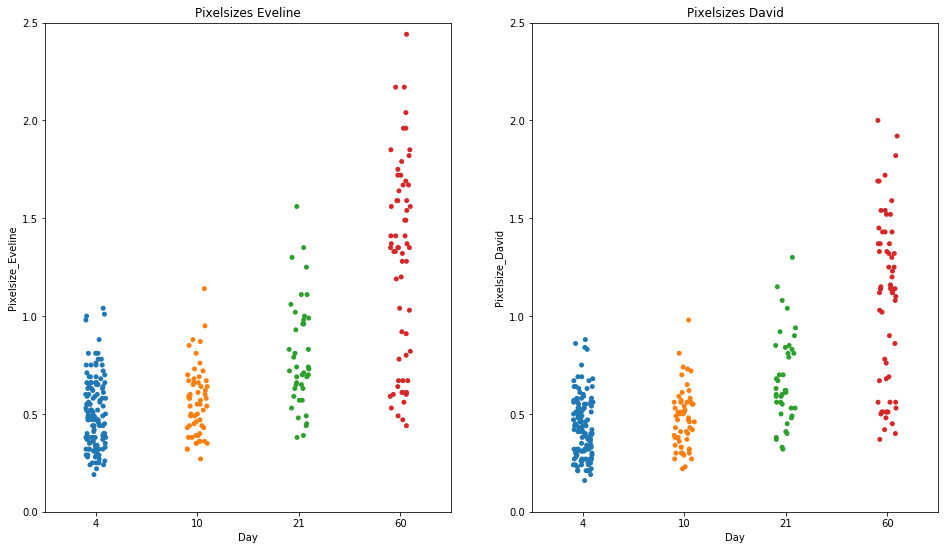

In [61]:
# Compare data
plt.subplot(121)
seaborn.stripplot(data=Done, x='Day', y='Pixelsize_Eveline', jitter=True)
plt.ylim([0, 2.5])
plt.title('Pixelsizes Eveline')
plt.subplot(122)
seaborn.stripplot(data=Done, x='Day', y='Pixelsize_David', jitter=True)
plt.title('Pixelsizes David')
plt.ylim([0, 2.5])
plt.show()

In [62]:
# Set ourselves a palette, based on the individual unique sample names
# The dictionary palette setting is based on the comments in https://stackoverflow.com/q/36554075/323100
ourcolors = seaborn.color_palette('husl', len(pandas.unique(Eveline.Animal)))
ourpalette = {animal: ourcolors[c] for c, animal in enumerate(pandas.unique(Eveline.Animal))}

In [63]:
# Set indivdual measurement color (in dataframe)
Eveline['Color'] = [None] * len(Eveline)
for c, animal in enumerate(Eveline.Animal):
    for d, i in enumerate(pandas.unique(Eveline.Animal)):
        if animal == i:
            Eveline.set_value(c, 'Color', ourcolors[d])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Load the volume data directly from `anatera4`, where I originally exported the DICOM files from MeVisLab (and where the data still is).
After doing that, we save it to a dataframe on disk, since looking for all the DICOM files takes nearly an hour...

In [64]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    drive = '/run/user/1000/gvfs/smb-share:server=anatera4,share='
else:
    drive = '\\\\anatera4\\'
# Load the data from this folder
terastation = drive + os.path.join('share', 'SLS')
print('We are loading all the data from %s' % terastation)

We are loading all the data from \\anatera4\share\SLS


In [65]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Volumes = 'VolumesFromDisk_' + get_git_hash() + '.pkl'

In [66]:
useoldvolumefile = True
if useoldvolumefile:
    try:
        # Use the *newest* VolumesFromDisk file, even if it's from another git hash
        OutputName_Volumes = max(glob.iglob('VolumesFromDisk*.pkl'), key=os.path.getctime)
    except ValueError:
        useoldvolumefile = False
        print('We *need* to generate a new volume file, since we found none...')

In [67]:
if get_git_hash() != os.path.splitext(OutputName_Volumes.split('_')[1])[0]:
    print('Hash (%s) is not the same as OutputName_Volumes (%s).' % (get_git_hash(), OutputName_Volumes))
    print('We are using the old file: %s' % OutputName_Volumes)
else:
    print('Hash (%s) is equal to the name of the OutputName_Volumes file name (%s).' % (get_git_hash(), OutputName_Volumes))

Hash (abbb2f3) is not the same as OutputName_Volumes (VolumesFromDisk_da3bdfb.pkl).
We are using the old file: VolumesFromDisk_da3bdfb.pkl


In [68]:
# Get a list of *all* DICOM files that I exported aeons ago
# Based on https://stackoverflow.com/a/14798263
# This takes between 30 and 60 minutes!!!
# We thus only do it if we cannot read the dataframe with all the data that we save later on...
if os.path.exists(OutputName_Volumes):
    print('We load the data from %s' % OutputName_Volumes)
else:
    print('We scan %s for "R108*.dcm" files' % terastation)
    tic = timeit.default_timer()
    AcinarVolumeFiles = sorted(glob.glob(os.path.join(terastation, '**/R108*.dcm'), recursive=True))
    toc = timeit.default_timer()
    print('We found %s DICOM files in %s minutes' % (len(AcinarVolumeFiles),
                                                     round(float((toc - tic) / 60.), 1)))

We load the data from VolumesFromDisk_da3bdfb.pkl


In [69]:
# Collect the data into a dataframe
if os.path.exists(OutputName_Volumes):
    # We already did it once, so just load it...
    VolumesFromDisk = pandas.read_pickle(OutputName_Volumes)
else:
    # Save the file locations into an empty dataframe
    VolumesFromDisk = pandas.DataFrame({'Location_Volume': AcinarVolumeFiles})

In [70]:
# # Grab relevant data from filenames (used to get the string matching right...)
# for f in AcinarVolumeFiles:
#     print(os.path.basename(f))
#     print('Animal', os.path.basename(f).split('R108C')[1].split('mrg.')[0][:-2])
#     print('Day', os.path.basename(f).split('R108C')[1].split('mrg')[0][:2])
#     print('Acinus', os.path.basename(f).split('.acinus')[1].split('.volume')[0])
#     print('Volume_MeVisLab', os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
#     print('Scantime', os.path.dirname(f).split('SLS')[1].split(os.sep)[1])
#     print(80*'-')

In [71]:
# # Some names (see output of this cell) derive from the R108C$Day$$Animal$ scheme.
# # We catch them with the intricate .split() in the cells below...
# for i in VolumesFromDisk.File:
#     if len(i.split('mrg')[0][len('R108C'):-2]) >3:
#         tmp.append(i.split('mrg')[0][len('R108C'):-2])
# for i in pandas.unique(tmp):
#     print(i)

In [72]:
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk['Filename_Volume'] = [os.path.basename(f) for f in AcinarVolumeFiles]
    VolumesFromDisk['Animal'] = [os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C') + 3]
                                 for f in AcinarVolumeFiles]
    VolumesFromDisk['Beamtime'] = [os.path.dirname(f).split('SLS')[1].split(os.sep)[1]
                                   for f in AcinarVolumeFiles]
    VolumesFromDisk['Day'] = [int(os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C') + 2])
                              for f in AcinarVolumeFiles]
    VolumesFromDisk['Acinus'] = [int(os.path.basename(f).split('.acinus')[1].split('.volume')[0])
                                 for f in AcinarVolumeFiles]
    # According to the MeVisLab files, the volume is saved to the file name in 'ul'. Which is equal to mm^3
    VolumesFromDisk['Volume_MeVisLab'] = [float(os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
                                          for f in AcinarVolumeFiles]  # mm^3

In [73]:
# Drop Day 36
# https://stackoverflow.com/a/27360130/323100
VolumesFromDisk.drop(VolumesFromDisk[VolumesFromDisk['Day'] == 36].index, inplace=True)
print('If we drop day 36, we now have %s acini' % len(VolumesFromDisk))

If we drop day 36, we now have 702 acini


In [74]:
# Save the data if it doesn't exist already
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk.to_pickle(OutputName_Volumes)

In [75]:
VolumesFromDisk.groupby(by=['Day', 'Animal'])['Volume_MeVisLab'].describe()

count      mean       std       min       25%       50%       75%  \
Day Animal                                                                      
4   04A      51.0  0.005778  0.005166  0.000918  0.002298  0.003587  0.007537   
    04B      23.0  0.035109  0.034599  0.006500  0.013876  0.022904  0.034274   
    04C      51.0  0.028898  0.024524  0.004333  0.012543  0.023724  0.038294   
    04D      44.0  0.024475  0.023928  0.003994  0.009371  0.016748  0.027254   
    04E      43.0  0.011132  0.009397  0.001216  0.004316  0.009308  0.012664   
10  10A      32.0  0.017683  0.011906  0.002228  0.006594  0.014849  0.025849   
    10B      27.0  0.017440  0.014117  0.003091  0.005615  0.013327  0.020489   
    10C      69.0  0.028546  0.034399  0.001266  0.007853  0.015728  0.035606   
    10D      34.0  0.019566  0.012316  0.005223  0.012436  0.015605  0.025856   
    10E      33.0  0.010937  0.007567  0.002034  0.005457  0.007357  0.017192   
21  21A      24.0  0.043471  0.036621  0.003041  0.018055  0.029545  0.065106   
    21B      42.0  0.046559  0.037820  0.006527  0.018710  0.039733  0.057297   
    21D      94.0  0.068710  0.082583  0.001512  0.020657  0.034159  0.082559   
    21E      51.0  0.078594  0.067957  0.007258  0.035371  0.061948  0.103770   
60  60B      24.0  0.319332  0.132694  0.133954  0.224747  0.306324  0.426902   
    60C      41.0  0.039036  0.029254  0.005616  0.018427  0.029921  0.045526   
    60D      10.0  0.434013  0.128309  0.232298  0.322434  0.440845  0.545049   
    60E       9.0  0.459532  0.225806  0.124868  0.337419  0.511632  0.670989   

                 max  
Day Animal            
4   04A     0.021516  
    04B     0.120925  
    04C     0.134680  
    04D     0.108391  
    04E     0.046470  
10  10A     0.049147  
    10B     0.051696  
    10C     0.171791  
    10D     0.053397  
    10E     0.030101  
21  21A     0.144457  
    21B     0.215823  
    21D     0.393451  
    21E     0.347160  
60  60B     0.667457  
    60C     0.130595  
    60D     0.590029  
    60E     0.752025

In [76]:
# In the segmentation, we also include the ductal airspace.
# Stefan and Lilian (Tschanz2014, Table 1) assessed these values, we'll use then for the volume correction below
DuctalToAlveolar = [0.113/0.486,
                    0.230/0.880,
                    0.594/1.910,
                    #0.973/3.956,
                    1.292/5.645]

In [77]:
print('MeVisLab Volumes\n')
# Give out alveolar volumes per day
for c, day in enumerate(sorted(Eveline.Day.unique())):
    print('Day %02d' % day)
    cts = numpy.mean(Eveline.loc[Eveline.Day == day]['Counts'])
    print('Mean count from Eveline: %4.2f' % cts)
    # Acinus volume (*including* Ductus...), converted  from mm^3  to um^3
    # https://encrypted.google.com/search?hl=en&q=cubic%20millimeter%20to%20cubic%20micrometer
    vol = numpy.mean(VolumesFromDisk.loc[VolumesFromDisk.Day == day]['Volume_MeVisLab']) * 1e9
    # Remove the ductal airspace, as assessed by Tschanz2014
    vol = vol - (DuctalToAlveolar[c] * vol)
    print('Mean volume per acinus (MeVisLab): %0.2f um^3' % vol)
    # Acinus size
    # Volume --> Radius
    # v = 4/3 * pi * r^3
    # r = ((3/4) * v / pi ) ^ 1/3
    # r * 2 = diameter
    print('Mean diameter of one acinus: %4.2f um' % (2 * (numpy.cbrt(3 / 4 * vol / numpy.pi))))
    # Alveolus volume and size
    print('Mean volume per alveolus: %0.2f um^3' % (vol / cts))
    print('Mean diameter of one alveolus: %4.2f um' % (2 * (numpy.cbrt(3 / 4 * (vol / cts )/ numpy.pi))))          
    print(80 * '-')
# https://www.wolframalpha.com/input/?i=sphere+with+volume+of+2.11e%2B08+ul

MeVisLab Volumes

Day 04
Mean count from Eveline: 47.85
Mean volume per acinus (MeVisLab): 14957045.63 um^3
Mean diameter of one acinus: 305.69 um
Mean volume per alveolus: 312550.33 um^3
Mean diameter of one alveolus: 84.20 um
--------------------------------------------------------------------------------
Day 10
Mean count from Eveline: 88.53
Mean volume per acinus (MeVisLab): 15274900.85 um^3
Mean diameter of one acinus: 307.84 um
Mean volume per alveolus: 172530.53 um^3
Mean diameter of one alveolus: 69.07 um
--------------------------------------------------------------------------------
Day 21
Mean count from Eveline: 233.33
Mean volume per acinus (MeVisLab): 43971758.46 um^3
Mean diameter of one acinus: 437.92 um
Mean volume per alveolus: 188450.39 um^3
Mean diameter of one alveolus: 71.13 um
--------------------------------------------------------------------------------
Day 60
Mean count from Eveline: 511.95
Mean volume per acinus (MeVisLab): 162857607.02 um^3
Mean diameter of

In [78]:
print('Stepanizered Volumes\n')
# Give out alveolar volumes per day
for day in sorted(Eveline.Day.unique()):
    print('Day %02d' % day)
    cts = numpy.mean(Eveline.loc[Eveline.Day == day]['Counts'])
    print('Mean count from Eveline: %0.2f' % cts)
    # Acinus Volume (*including* Ductus...), converted  from mm^3  to um^3
    # https://encrypted.google.com/search?hl=en&q=cubic%20millimeter%20to%20cubic%20micrometer
    vol = numpy.mean(David.loc[David.Day == day]['Acinusvolume']) * 1e9
    # Remove the ductal airspace, as assessed by Tschanz2014
    vol = vol - (DuctalToAlveolar[c] * vol)    
    print('Mean volume (STEPanizer): %0.2f um^3' % vol)
    # Acinus size
    # Volume --> Radius
    # v = 4/3 * pi * r^3
    # r = ((3/4) * v / pi ) ^ 1/3
    # r * 2 = diameter
    print('Mean diameter of one acinus: %0.2f um' % (2 * (numpy.cbrt(3 / 4 * vol / numpy.pi))))
    # Alveolus volume and size
    print('Mean volume per alveolus: %0.2f um^3' % (vol / cts))
    print('Mean diameter of one alveolus: %0.2f um' % (2 * (numpy.cbrt(3 / 4 * (vol / cts )/ numpy.pi))))              
    print(80 * '-')
# https://www.wolframalpha.com/input/?i=sphere+with+volume+of+2.11e%2B08+ul

Stepanizered Volumes

Day 04
Mean count from Eveline: 47.85
Mean volume (STEPanizer): 25337092.52 um^3
Mean diameter of one acinus: 364.41 um
Mean volume per alveolus: 529457.28 um^3
Mean diameter of one alveolus: 100.37 um
--------------------------------------------------------------------------------
Day 10
Mean count from Eveline: 88.53
Mean volume (STEPanizer): 30878042.07 um^3
Mean diameter of one acinus: 389.24 um
Mean volume per alveolus: 348768.54 um^3
Mean diameter of one alveolus: 87.33 um
--------------------------------------------------------------------------------
Day 21
Mean count from Eveline: 233.33
Mean volume (STEPanizer): 80135510.78 um^3
Mean diameter of one acinus: 534.90 um
Mean volume per alveolus: 343437.90 um^3
Mean diameter of one alveolus: 86.89 um
--------------------------------------------------------------------------------
Day 60
Mean count from Eveline: 511.95
Mean volume (STEPanizer): 402044931.08 um^3
Mean diameter of one acinus: 915.71 um
Mean vol

In [79]:
# Update palette, since we might have more animals than what we had above in cell 19
ourcolors = seaborn.color_palette('husl', len(pandas.unique(VolumesFromDisk.Animal)))
ourpalette = {animal: ourcolors[c] for c, animal in enumerate(sorted(pandas.unique(VolumesFromDisk.Animal)))}

In [80]:
# Drop day 60C
# WE NEED TO DISCUSS THIS IN THE PAPER IF WE DROP THIS clear OUTLIER
DropDay60C = True
if DropDay60C:
    Done.drop(Done[Done['Animal'] == '60C'].index, inplace=True)
    VolumesFromDisk.drop(VolumesFromDisk[VolumesFromDisk['Animal'] == '60C'].index, inplace=True)
    David.drop(David[David['Animal'] == '60C'].index, inplace=True)

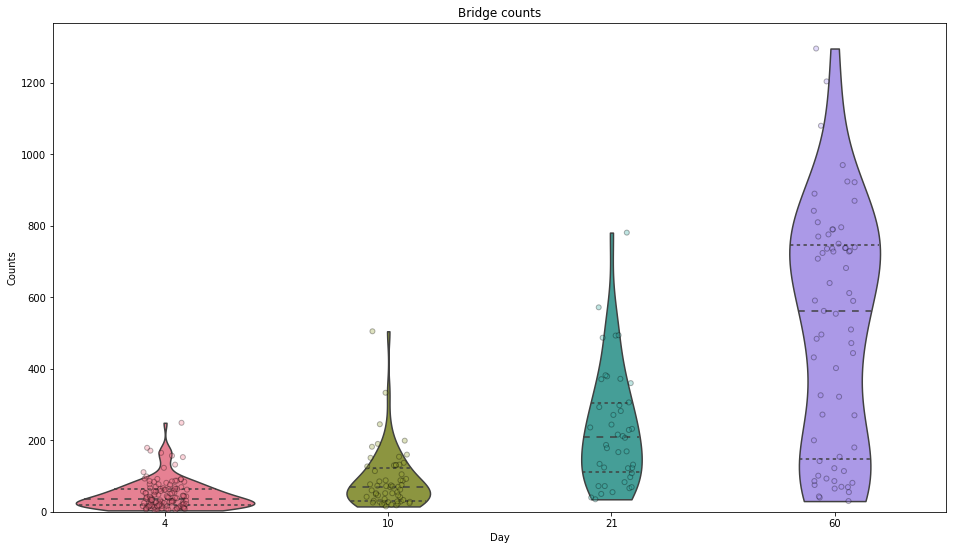

In [81]:
seaborn.violinplot(data=Eveline, x='Day', y='Counts', cut=0, scale='count',
                   palette=seaborn.color_palette('husl', len(pandas.unique(Eveline.Day))),
                   inner='quartiles')
seaborn.stripplot(data=Eveline, x='Day', y='Counts', linewidth=1, jitter=True,
                  palette=seaborn.color_palette('husl', len(pandas.unique(Eveline.Day))),
                  edgecolor='k', alpha=0.309)
plt.title('Bridge counts')
plt.ylim(ymin=0)
plt.savefig(os.path.join(imgdir, 'counts_global.png'), bbox_inches='tight')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2586: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


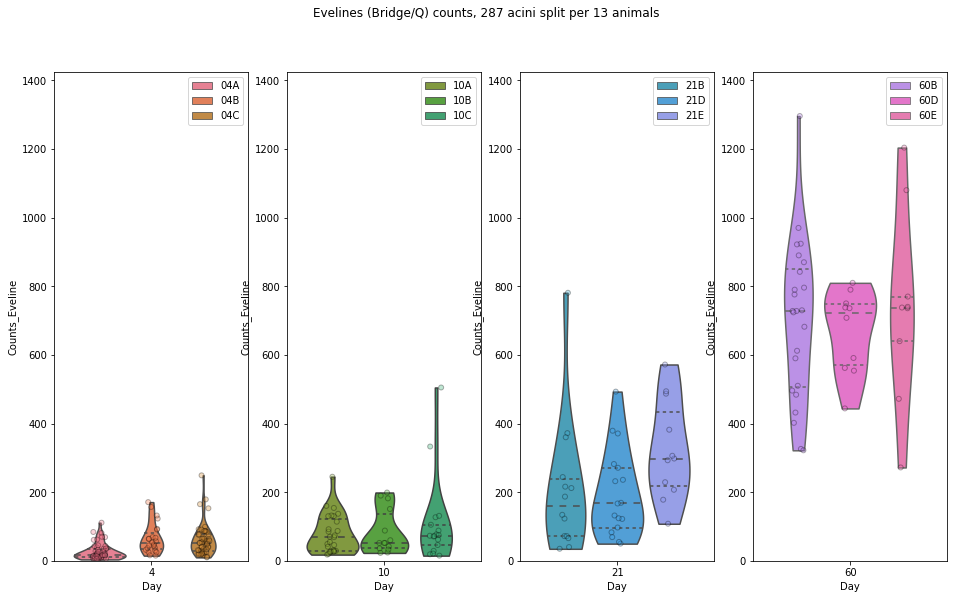

In [82]:
for c, d in enumerate(sorted(pandas.unique(Eveline.Day))):
    plt.subplot(1, len(pandas.unique(Done.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Done.loc[Done.Day == d], x='Day', y='Counts_Eveline',
                               hue='Animal',
                               # Because the animals are preferentially sorted on the beamtime name, we have
                               # to jump through the hoop below and sort the hues on the 'Animal' in addition
                               # to what we did for Evelines counts where all the data is in *one* folder
                               # Just comment the next line to see the difference (a correct plot, but ugly sort :)
                               hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Done.loc[Done.Day == d], x='Day', y='Counts_Eveline', hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Done.Counts_Eveline.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2])
plt.suptitle('Evelines (Bridge/Q) counts, %s acini split per %s animals' % (len(Eveline),
                                                                            len(pandas.unique(Eveline.Animal))))
plt.savefig(os.path.join(imgdir, 'counts_day-eveline.png'), bbox_inches='tight')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2586: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


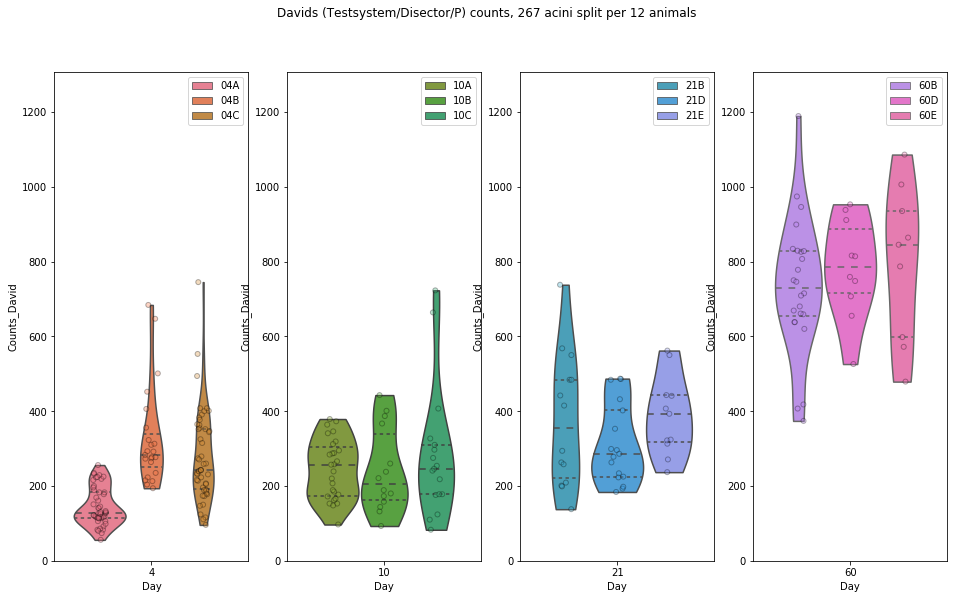

In [83]:
for c, d in enumerate(sorted(pandas.unique(Done.Day))):
    plt.subplot(1, len(pandas.unique(Done.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Done.loc[Done.Day == d], x='Day', y='Counts_David',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Done.loc[Done.Day == d], x='Day', y='Counts_David', hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Done.Counts_David.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='upper right')
plt.suptitle('Davids (Testsystem/Disector/P) counts, %s acini split per %s animals' % (len(David),
                                                                                       len(pandas.unique(David.Animal))))
plt.savefig(os.path.join(imgdir, 'counts_day-david.png'), bbox_inches='tight')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2586: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


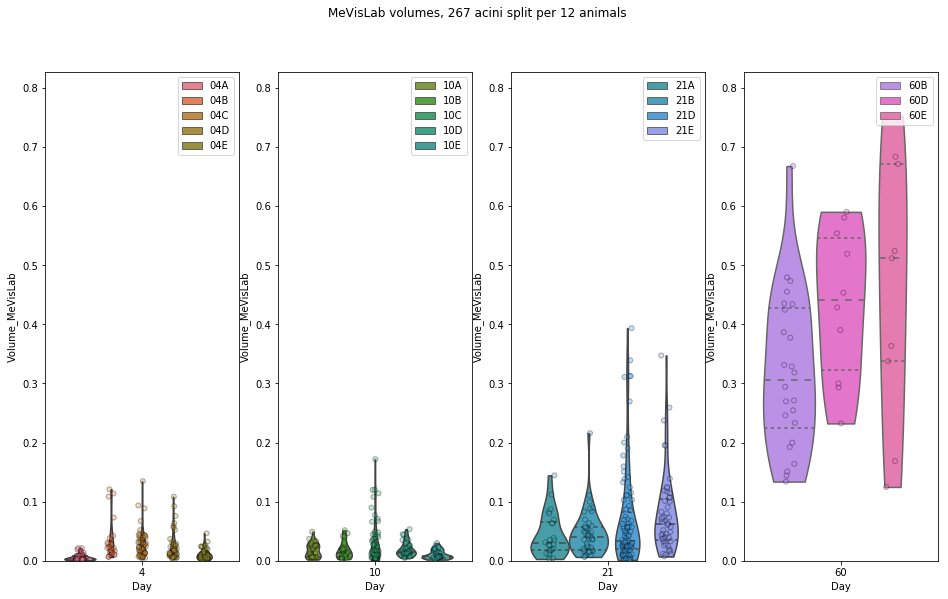

In [84]:
for c, d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
    plt.subplot(1, len(pandas.unique(VolumesFromDisk.Day)), c + 1)
    bxplt = seaborn.violinplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d], x='Day', y='Volume_MeVisLab',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d], x='Day', y='Volume_MeVisLab', hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * VolumesFromDisk.Volume_MeVisLab.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='upper right')
plt.suptitle('MeVisLab volumes, %s acini split per %s animals' % (len(David),
                                                                  len(pandas.unique(David.Animal))))
# plt.savefig(os.path.join(imgdir, 'counts_day-david.png'), bbox_inches='tight')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2586: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


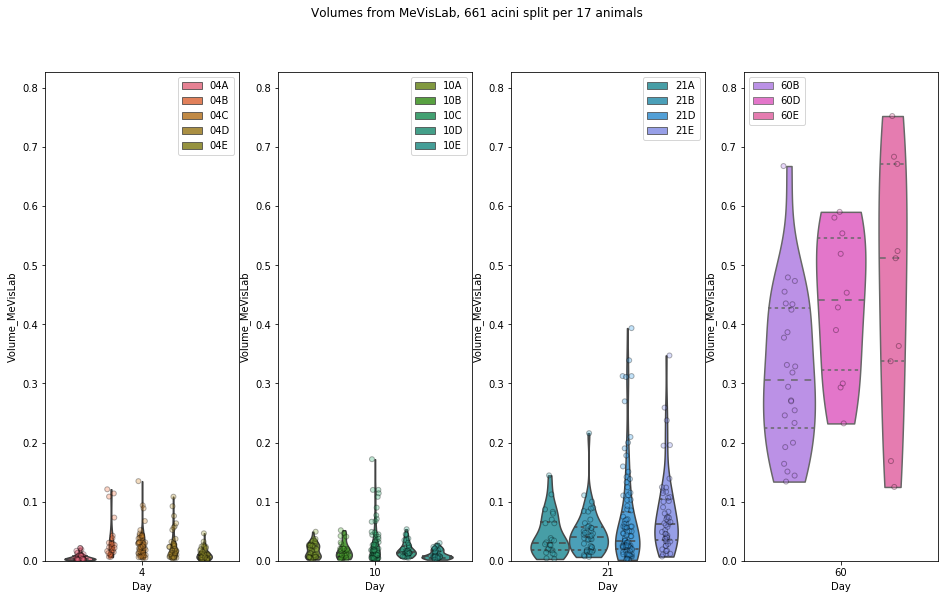

In [85]:
for c, d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
    plt.subplot(1, len(pandas.unique(VolumesFromDisk.Day)), c + 1)
    bxplt = seaborn.violinplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d],
                               x='Day', y='Volume_MeVisLab',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d],
                                x='Day', y='Volume_MeVisLab',
                                hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * VolumesFromDisk.Volume_MeVisLab.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2])
plt.suptitle('Volumes from MeVisLab, %s acini split per %s animals' % (len(VolumesFromDisk),
                                                                       len(pandas.unique(VolumesFromDisk.Animal))))
plt.savefig(os.path.join(imgdir, 'volumes_day-disk.png'), bbox_inches='tight')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2586: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


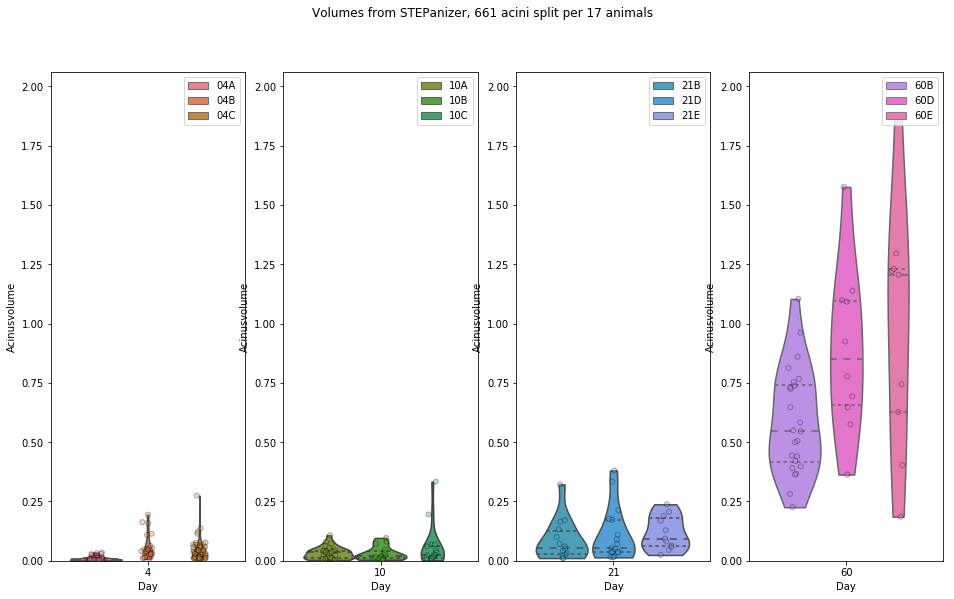

In [86]:
for c, d in enumerate(sorted(pandas.unique(Done.Day))):
    plt.subplot(1, len(pandas.unique(Done.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Done.loc[Done.Day == d], x='Day', y='Acinusvolume',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Done.loc[Done.Day == d], x='Day', y='Acinusvolume', hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Done.Acinusvolume.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2], loc='upper right')
plt.suptitle('Volumes from STEPanizer, %s acini split per %s animals' % (len(VolumesFromDisk),
                                                                         len(pandas.unique(VolumesFromDisk.Animal))))
plt.savefig(os.path.join(imgdir, 'volumes_day-disector.png'), bbox_inches='tight')
plt.show()

Now we merge the Eveline/David/Done and VolumesFromDisk dataframes

In [87]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Merged = 'Merged_' + get_git_hash() + '.pkl'

In [88]:
# Merge the dataframes: http://pandas.pydata.org/pandas-docs/stable/merging.html
# This seems to discard all entries that are *not* found in both df's
if os.path.exists(OutputName_Merged):
    # We already did it once, so just load it...
    Merged = pandas.read_pickle(OutputName_Merged)
else:
    Merged = pandas.merge(Done, VolumesFromDisk)

In [89]:
# Doublecheck merged file names (for some randomly selected items from the dataframe)
# To make the checking a bit easier, we split the strings and only show the interesting bit
for i in range(5):
    number = numpy.random.randint(len(Merged))
    print('Beamtime:', Merged.iloc[number]['Beamtime'])
    print('From Volume: Animal', Merged.iloc[number].Filename_Volume.split('mrg.')[0],
          '| Acinus', Merged.iloc[number].Filename_Volume.split('acinus')[1].split('.volume')[0],
          '| Volume', Merged.iloc[number]['Volume_MeVisLab'])
    print('From Done: Animal', Merged.iloc[number].Filename_Eveline.split('mrg-')[0][1:],
          '| Acinus', Merged.iloc[number].Filename_Eveline.split('acinus')[1].split('_201')[0],
          '| Counts', Merged.iloc[number]['Counts_Eveline'])
    print(40 * '-')

Beamtime: 2010a
From Volume: Animal R108C04At- | Acinus 88 | Volume 0.0033932494
From Done: Animal R108C04At- | Acinus 88 | Counts 26.0
----------------------------------------
Beamtime: 2010a
From Volume: Animal R108C04At- | Acinus 48 | Volume 0.013611587
From Done: Animal R108C04At- | Acinus 48 | Counts 81.0
----------------------------------------
Beamtime: 2010c_tape
From Volume: Animal R108C60B_B1_ | Acinus 15 | Volume 0.45502964
From Done: Animal R108C60B_B1_ | Acinus 15 | Counts 922.0
----------------------------------------
Beamtime: 2010c_tape
From Volume: Animal R108C21E_B1_ | Acinus 56 | Volume 0.10647043
From Done: Animal R108C21E_B1_ | Acinus 56 | Counts 382.0
----------------------------------------
Beamtime: 2010a
From Volume: Animal R108C21Bt- | Acinus 54 | Volume 0.014756225
From Done: Animal R108C21Bt- | Acinus 54 | Counts 66.0
----------------------------------------


In [90]:
# Did we count a different amount of images?
Merged['ImageCountDifference'] = Merged['Number of images_David'] - Merged['Number of images_Eveline']

In [91]:
# See the difference
Merged.sort_values('ImageCountDifference', ascending=False)[['Location_David',
                                                             'Sample',
                                                             'Animal',
                                                             'Acinus',
                                                             'ImageCountDifference']].head(n=5)

,Location_David,Sample,Animal,Acinus,ImageCountDifference
69,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04Bt...,R108C04Bt-mrg,04B,3,34
92,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04Ct...,R108C04Ct-mrg,04C,0,1
145,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C10At...,R108C10At-mrg,10A,9,1
182,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C10Bt...,R108C10Bt-mrg,10B,41,0
181,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C10Bt...,R108C10Bt-mrg,10B,39,0


In [92]:
if not os.path.exists(OutputName_Merged):
    Merged['CpV'] = Merged['Counts_Eveline'] / Merged['Volume_MeVisLab']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2586: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


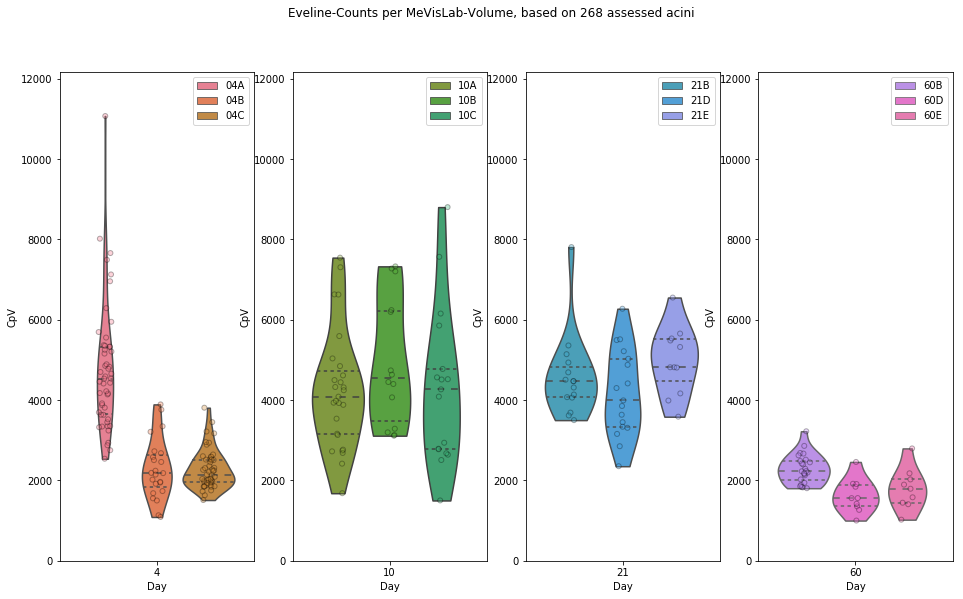

In [93]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                   palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                                hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Merged.CpV.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2])
plt.suptitle('Eveline-Counts per MeVisLab-Volume, based on %s assessed acini' % len(Merged))
plt.savefig(os.path.join(imgdir, 'counts_per_volume_day_eveline-disk.png'), bbox_inches='tight')
plt.show()

In [94]:
if not os.path.exists(OutputName_Merged):
    Merged['CpSV'] = Merged['Counts_Eveline'] / Merged['Acinusvolume']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:2586: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


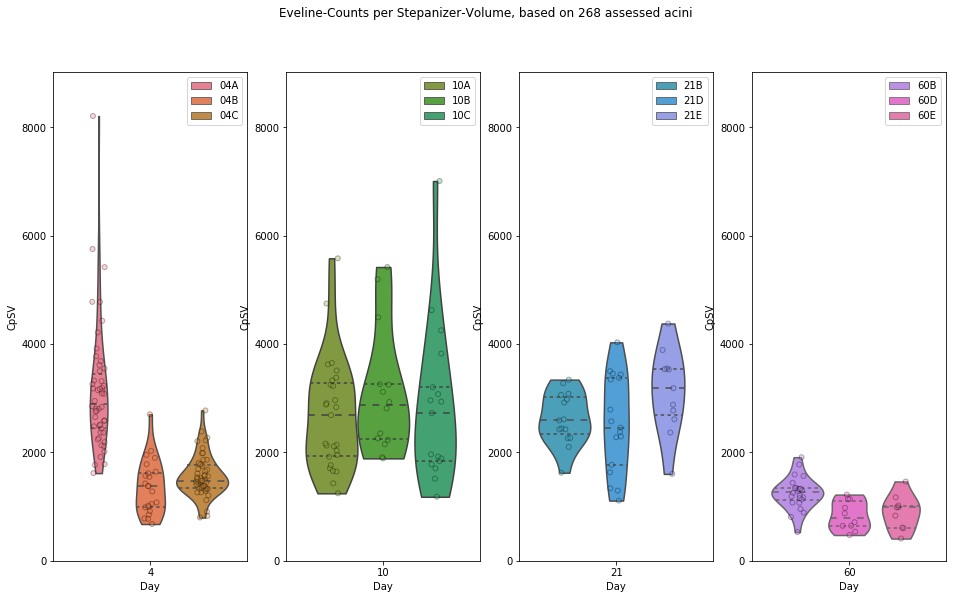

In [95]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpSV',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                   palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.stripplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpSV',
                                hue='Animal', jitter=True,
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Merged.CpSV.max()])
    bxplt.legend(handles[:len(handles) // 2], labels[:len(labels) // 2])
plt.suptitle('Eveline-Counts per Stepanizer-Volume, based on %s assessed acini' % len(Merged))
plt.savefig(os.path.join(imgdir, 'counts_per_volume_day_eveline-stepanizer.png'), bbox_inches='tight')
plt.show()

In [96]:
Merged.loc[Merged['CpSV'] == max(Merged['CpSV'])]

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,...,Area per point,Acinusvolume,Number of images_David,_merge,Location_Volume,Filename_Volume,Volume_MeVisLab,ImageCountDifference,CpV,CpSV
34,/media/habi/Fast_SSD/Acini/2010a/mrg/R108C04At...,_R108C04At-mrg-acinus43_2013-04-02_14-02_resul...,2010a,R108C04At-mrg,04A,4,43,35.0,0.22,28,...,1241.89,0.004264,28,both,"/run/user/1000/gvfs/smb-share:server=anatera4,...",R108C04At-mrg.2936x2936x1024.gvr.acinus43.volu...,0.003161,0,11073.600783,8207.959673


In [97]:
Merged.loc[Merged['CpSV'] == min(Merged['CpSV'])]

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,...,Area per point,Acinusvolume,Number of images_David,_merge,Location_Volume,Filename_Volume,Volume_MeVisLab,ImageCountDifference,CpV,CpSV
14,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Et...,_R108C60Et-mrg-acinus08_2012-09-27_13-47_resul...,2009f,R108C60Et-mrg,60E,60,8,770.0,2.17,141,...,116632.6,1.874612,141,both,"/run/user/1000/gvfs/smb-share:server=anatera4,...",R108C60Et-mrg.2444.2944.1024.gvr.acinus8.volum...,0.752025,0,1023.901954,410.751566


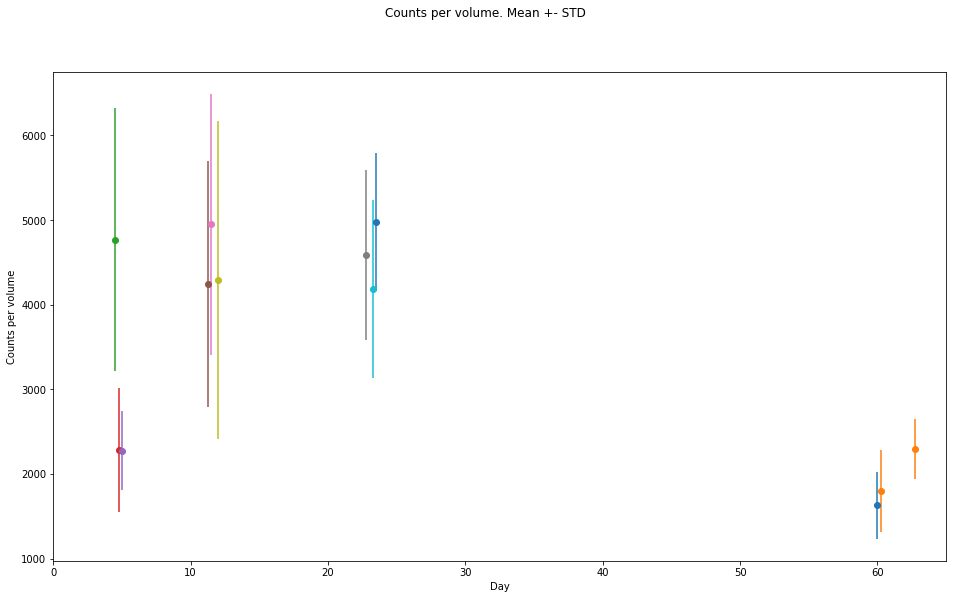

In [98]:
# Plot mean +- STD
for c, d in enumerate(pandas.unique(Merged.Animal)):
    # print(d)
    # print(numpy.mean(Merged.loc[Merged.Animal == d]['Day']))
    # print(numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    # print(numpy.std(Merged.loc[Merged.Animal == d]['CpV']))
    # plt.scatter(numpy.mean(Merged.loc[Merged.Animal == d]['Day']), numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    plt.errorbar(numpy.mean(Merged.loc[Merged.Animal == d]['Day']) + 0.25 * c % 5,
                 numpy.mean(Merged.loc[Merged.Animal == d]['CpV']),
                 yerr=numpy.std(Merged.loc[Merged.Animal == d]['CpV']),
                 fmt='o')
    plt.xlabel('Day')
    plt.ylabel('Counts per volume')
    plt.xlim([0, 65])
plt.suptitle('Counts per volume. Mean +- STD')
plt.savefig(os.path.join(imgdir, 'mean_counts_per_volume.png'), bbox_inches='tight')
plt.show()

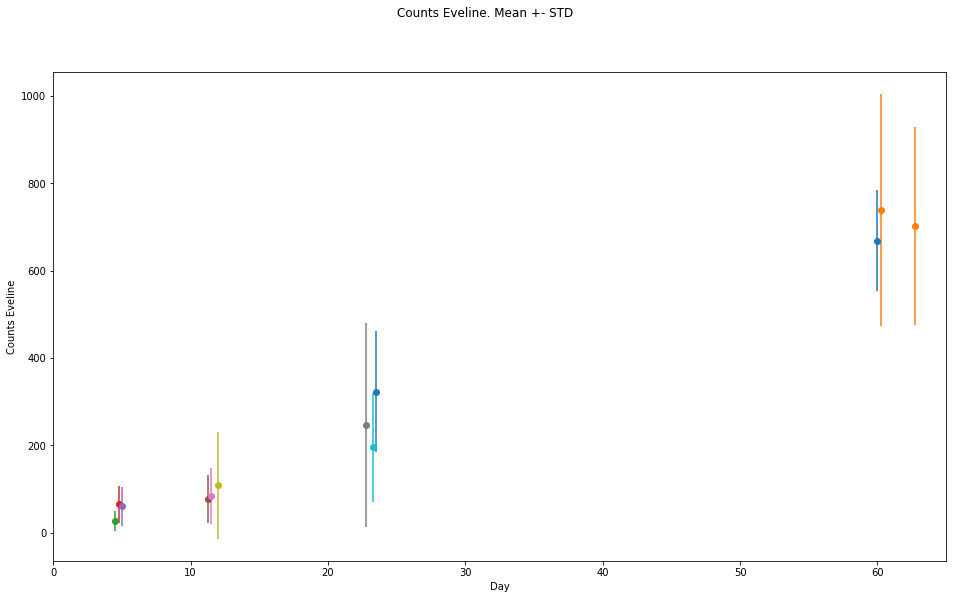

In [99]:
# Plot mean +- STD
for c, d in enumerate(pandas.unique(Merged.Animal)):
    #     print(d)
    #     print(numpy.mean(Merged.loc[Merged.Animal == d]['Day']))
    #     print(numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    #     print(numpy.std(Merged.loc[Merged.Animal == d]['CpV']))
    #     plt.scatter(numpy.mean(Merged.loc[Merged.Animal == d]['Day']), numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    plt.errorbar(numpy.mean(Merged.loc[Merged.Animal == d]['Day']) + 0.25 * c % 5,
                 numpy.mean(Merged.loc[Merged.Animal == d]['Counts_Eveline']),
                 yerr=numpy.std(Merged.loc[Merged.Animal == d]['Counts_Eveline']),
                 fmt='o')
    plt.xlabel('Day')
    plt.ylabel('Counts Eveline')
    plt.xlim([0, 65])
plt.suptitle('Counts Eveline. Mean +- STD')
plt.savefig(os.path.join(imgdir, 'mean_counts.png'), bbox_inches='tight')
plt.show()

In [100]:
# Get the mean number of alveoli per acinus
print('Based on Tschanz2014 and Barre2014...')
# Number of alveoli (19.297e6) from Tschanz2014, Table 1, p. 91)
# Number of acini (5943) from Barre2014, Table 2, p. 7
n_alv = 19.279 * 1e6
n_acini = 5943
alv_pro_acinus = n_alv / n_acini
print('We have approximately %0.0f alveoli per acinus.' % alv_pro_acinus)
lung_volume = 10.21  # cm³
acinar_volume = lung_volume / n_acini
print('One acinus in D60 lungs thus has a volume of approximately %0.2g um^3.' % acinar_volume)

Based on Tschanz2014 and Barre2014...
We have approximately 3244 alveoli per acinus.
One acinus in D60 lungs thus has a volume of approximately 0.0017 um^3.


In [101]:
for d in [4, 10, 21, 60]:
    print('For day %2s we counted %3s acini' % (d, len(Merged[Merged.Day == d])))

For day  4 we counted 124 acini
For day 10 we counted  58 acini
For day 21 we counted  43 acini
For day 60 we counted  43 acini


In [102]:
# Save the data
if not os.path.exists(OutputName_Merged):
    Merged.to_pickle(OutputName_Merged)
    print('Saved "Merged" dataframe to %s as last step of the analysis' % OutputName_Merged)
else:
    print('Done!')

Done!


In [103]:
# Save all dataframes to different sheets in one big excel file
# Based on the bottom of https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_excel.html
writer = pandas.ExcelWriter('Data_' + get_git_hash() + '.xlsx')
Merged.to_excel(writer,'All data merged')
Done.to_excel(writer,'Eveline und David merged')
David.to_excel(writer,'David')
Eveline.to_excel(writer,'Eveline')
VolumesFromDisk.to_excel(writer,'Volumes from MeVisLab')
writer.save()

Let's compile a nice table

In [104]:
# HOW IS IT WITH THE SHRINKAGE FACTOR?

In [105]:
# Mean alveolar volumes
MeanAlveolarVolume = [None] * len(Merged.Day.unique())
MeanAcinarVolume = [None] * len(Merged.Day.unique())
MeanCounts = [None] * len(Merged.Day.unique())
for c, day in enumerate(sorted(Merged.Day.unique())):
    print('Day %s' % day)
    MeanCounts[c]= numpy.mean(Merged.loc[Merged.Day == day]['Counts_Eveline'])
    print('Mean counts: %4.2f' % MeanCounts[c])
    # Acinus volume (*including* Ductus...), converted  from mm^3  to um^3
    # https://encrypted.google.com/search?hl=en&q=cubic%20millimeter%20to%20cubic%20micrometer
    vol = numpy.mean(Merged.loc[Merged.Day == day]['Acinusvolume']) * 1e9 / ShrinkageFactor
    # Remove the ductal airspace, as assessed by Tschanz2014
    MeanAcinarVolume[c] = vol - (DuctalToAlveolar[c] * vol)
    print('Mean volume per acinus (ductal airspace removed): %0.3g um^3' % MeanAcinarVolume[c])
    MeanAlveolarVolume[c] = MeanAcinarVolume[c] / MeanCounts[c]
    print('Mean volume per alveolus: %0.3g um^3' % MeanAlveolarVolume[c])

Day 4
Mean counts: 47.85
Mean volume per acinus (ductal airspace removed): 4.13e+07 um^3
Mean volume per alveolus: 8.64e+05 um^3
Day 10
Mean counts: 88.53
Mean volume per acinus (ductal airspace removed): 4.85e+07 um^3
Mean volume per alveolus: 5.48e+05 um^3
Day 21
Mean counts: 246.07
Mean volume per acinus (ductal airspace removed): 1.23e+08 um^3
Mean volume per alveolus: 5e+05 um^3
Day 60
Mean counts: 701.79
Mean volume per acinus (ductal airspace removed): 9.35e+08 um^3
Mean volume per alveolus: 1.33e+06 um^3


In [106]:
# From Datenblattstefan.xls we copy the mean parenchymal volume
V_lung_par =[0.84,
             1.56,
             3.15,
             # 6.20,
             8.93]

In [107]:
V_az = [ma / 1e12 for ma in MeanAcinarVolume]
print(V_az)

[4.1340410419836755e-05, 4.8487063525958425e-05, 0.00012310344653656305, 0.0009346470485098781]


In [108]:
N_az = numpy.divide(V_lung_par, V_az)
print(N_az)

[20319.10161194 32173.5301451  25588.23565565  9554.40881586]


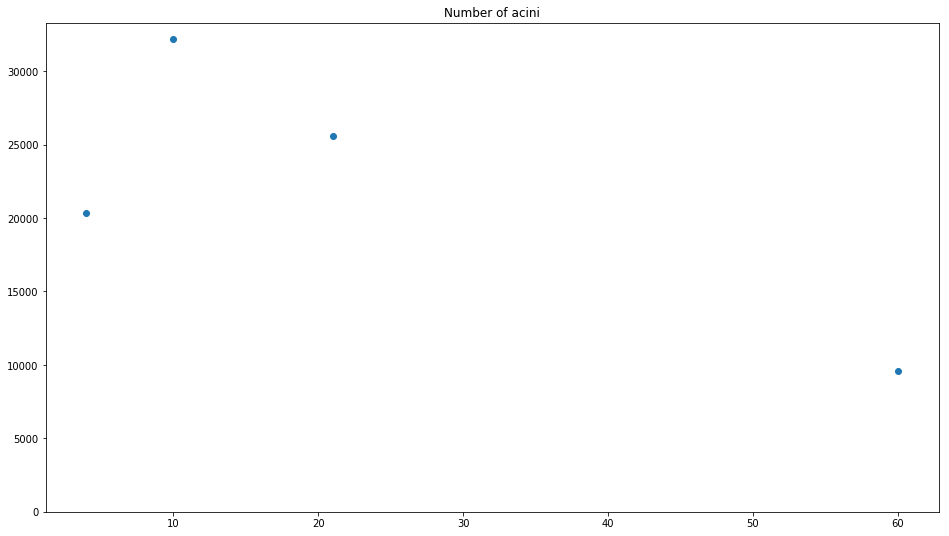

In [109]:
plt.scatter([4,10,21,60], N_az, marker='o')
plt.ylim(ymin=0)
plt.title('Number of acini')
plt.show()

In [110]:
N_alv_az = MeanCounts

In [111]:
N_alv_lung = N_az * N_alv_az

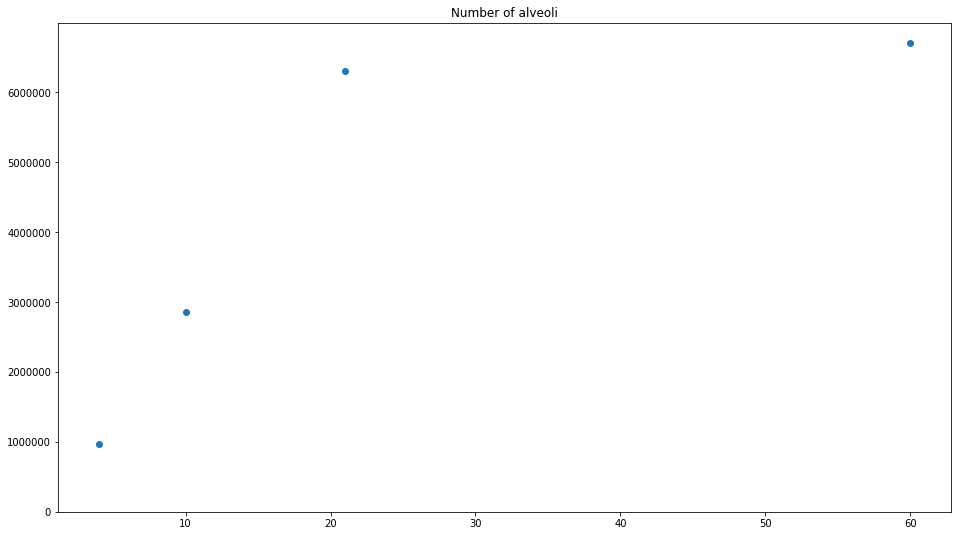

In [112]:
plt.scatter([4,10,21,60], N_alv_lung, marker='o')
plt.ylim(ymin=0)
plt.title('Number of alveoli')
plt.show()

In [113]:
for i in N_alv_lung:
    print('%0.2f * 1e6 alveoli' % (i * 1e-6))

0.97 * 1e6 alveoli
2.85 * 1e6 alveoli
6.30 * 1e6 alveoli
6.71 * 1e6 alveoli


N_alv_lung müsste in Etwa dassselbe wie bei Lilian sein

----
Alternative Berechnung der Alveolenzahl.
Anstatt über die Durchschnitte über die totalen Zahlen.

In [114]:
# From Datenblattstefan.xls we copy the mean airspace volume
V_lung_airspace =[0.65,
                  1.11,
                  2.37,
                  # 4.63,
                  6.74]
V_lung_airspace = [va * 1e12 for va in V_lung_airspace]

In [115]:
# Mean alveolar volumes
TotalAlveolarVolume = [None] * len(Merged.Day.unique())
TotalAcinarVolume = [None] * len(Merged.Day.unique())
TotalCounts = [None] * len(Merged.Day.unique())
for c, day in enumerate(sorted(Merged.Day.unique())):
    print('Day %s' % day)
    TotalCounts[c]= numpy.sum(Merged.loc[Merged.Day == day]['Counts_Eveline'])
    print('Total counts: %4.2f' % TotalCounts[c])
    # Acinus volume (*including* Ductus...), converted  from mm^3  to um^3
    # https://encrypted.google.com/search?hl=en&q=cubic%20millimeter%20to%20cubic%20micrometer
    # This volume *needs* to be corrected with the shrinkage factor
    TotalAcinarVolume[c] = numpy.sum(Merged.loc[Merged.Day == day]['Acinusvolume']) * 1e9 / ShrinkageFactor
    print('Total acinus volume: %0.3g um^3' % TotalAcinarVolume[c])
    TotalAlveolarVolume[c] = TotalAcinarVolume[c] / TotalCounts[c]
    print('Total alveolar volume: %0.3g um^3' % TotalAlveolarVolume[c])

Day 4
Total counts: 5934.00
Total acinus volume: 6.68e+09 um^3
Total alveolar volume: 1.13e+06 um^3
Day 10
Total counts: 5135.00
Total acinus volume: 3.81e+09 um^3
Total alveolar volume: 7.41e+05 um^3
Day 21
Total counts: 10581.00
Total acinus volume: 7.68e+09 um^3
Total alveolar volume: 7.26e+05 um^3
Day 60
Total counts: 30177.00
Total acinus volume: 5.21e+10 um^3
Total alveolar volume: 1.73e+06 um^3


In [116]:
N_alv_total = numpy.divide(numpy.multiply(TotalCounts, V_lung_airspace),
                           TotalAcinarVolume)

In [117]:
for i in N_alv_total:
    print('%0.2f * 1e6 alveoli' % (i * 1e-6))

0.58 * 1e6 alveoli
1.50 * 1e6 alveoli
3.26 * 1e6 alveoli
3.90 * 1e6 alveoli


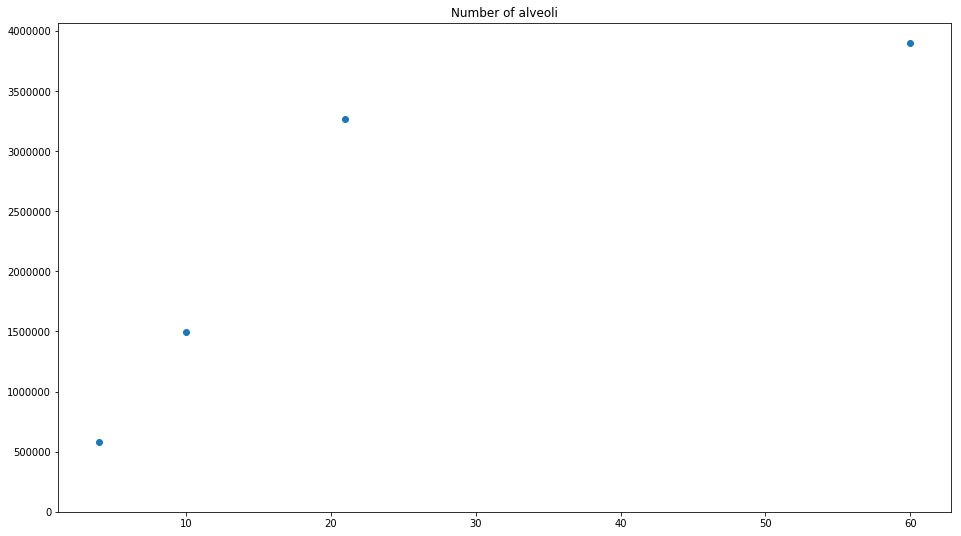

In [118]:
plt.scatter([4,10,21,60], N_alv_total, marker='o')
plt.ylim(ymin=0)
plt.title('Number of alveoli')
plt.show()

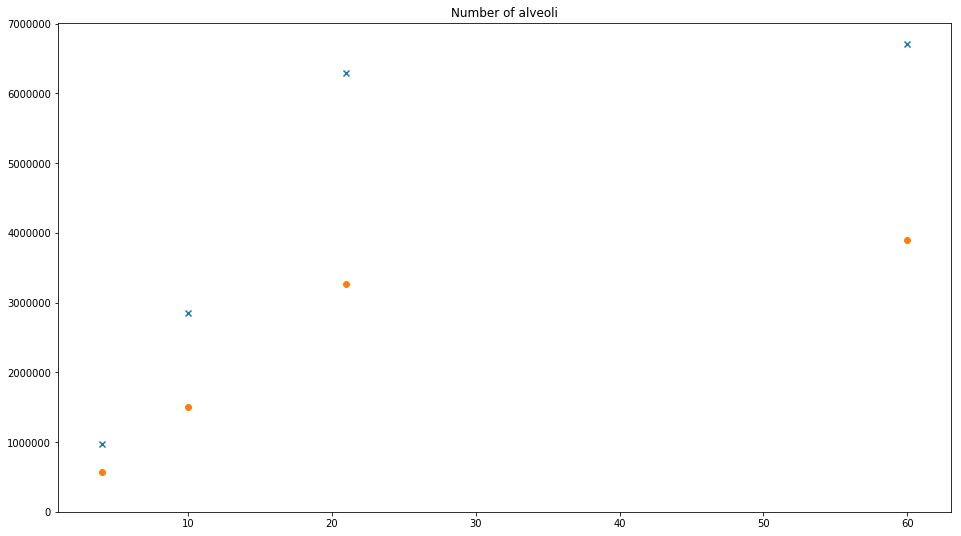

In [119]:
plt.scatter([4,10,21,60], N_alv_lung, marker='x')
plt.scatter([4,10,21,60], N_alv_total, marker='o')
plt.ylim(ymin=0)
plt.title('Number of alveoli')
plt.show()

Get a sampler of the tomography slices to compare them with microscopy slides.
E.g., get *one* acinus per day, get the middle image of it and then image this *physical* slice on the microscope.
(We got the slices from Stefan...)

In [284]:
Microscopy = pandas.DataFrame()
Microscopy['Location'] = [os.path.dirname(f) for f in Eveline.Location]
Microscopy['NumImages'] = [len(glob.glob(os.path.join(f, '*.jpg'))) for f in Microscopy.Location]
Microscopy['MiddleImage'] = Microscopy.NumImages // 4  # we have _a and _b series, so half of it is the image set, and again half of it is the middle image
Microscopy['SelectedImage'] = [glob.glob(os.path.join(f, '*' + str(mi) + '_a.jpg'))[0] for f,mi in zip(Microscopy.Location, Microscopy.MiddleImage)]

Microscopy['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in Eveline.Location]
Microscopy['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in Eveline.Location]
Microscopy['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in Eveline.Location]
Microscopy['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in Eveline.Location]

In [285]:
Microscopy.head()

,Location,NumImages,MiddleImage,SelectedImage,Sample,Animal,Day,Acinus
0,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus03\voxe...,186,46,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus03\voxe...,R108C60Dt-mrg,60D,60,3
1,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus04\voxe...,264,66,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus04\voxe...,R108C60Dt-mrg,60D,60,4
2,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus07\voxe...,240,60,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus07\voxe...,R108C60Dt-mrg,60D,60,7
3,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus09\voxe...,248,62,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus09\voxe...,R108C60Dt-mrg,60D,60,9
4,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus10\voxe...,220,55,F:/Acini\2009f\mrg\R108C60Dt-mrg\acinus10\voxe...,R108C60Dt-mrg,60D,60,10


In [286]:
# Select one sample per day
# Based on https://stackoverflow.com/a/41566012/323100
Subset = Microscopy.groupby('Day').apply(lambda x: x.sample())

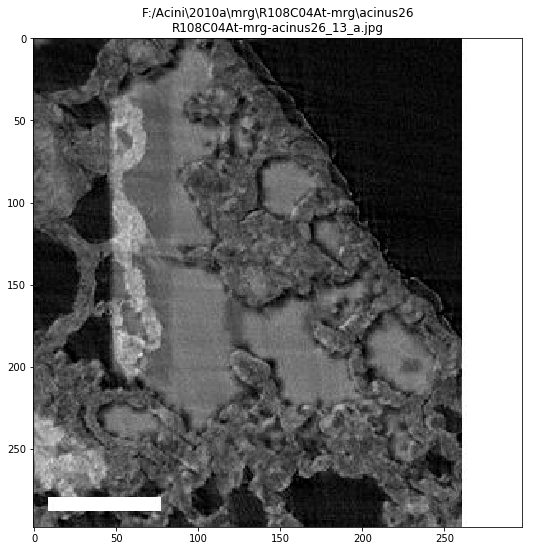

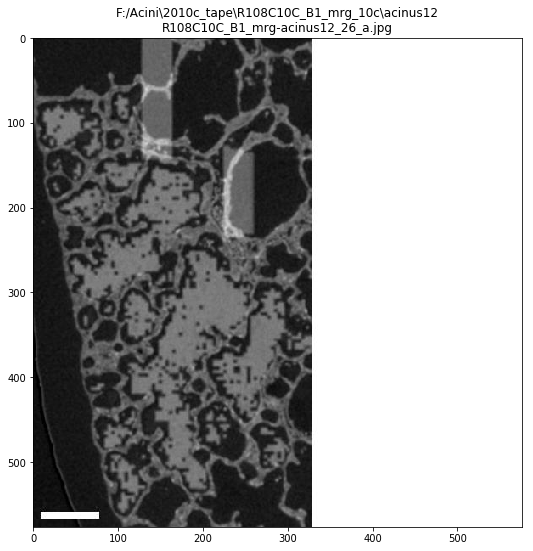

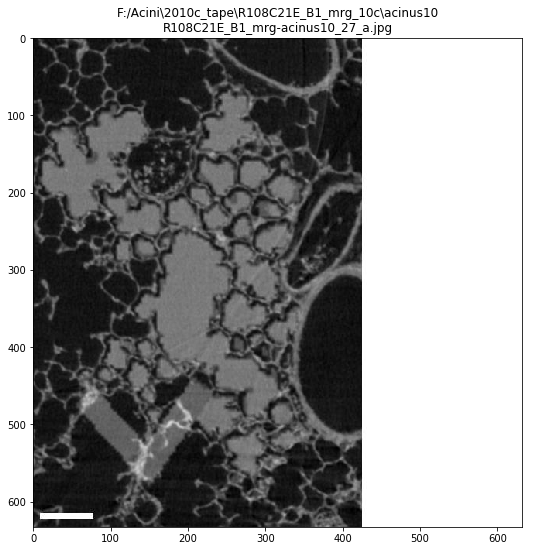

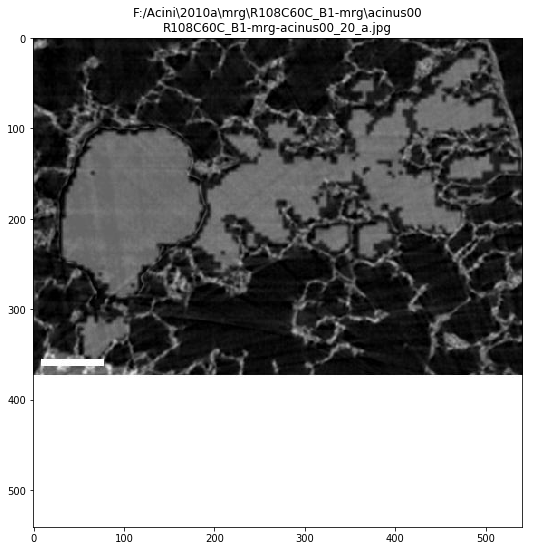

In [287]:
for c,i in enumerate(Subset['SelectedImage']):
#     plt.subplot(2,2,c+1)
    plt.imshow(plt.imread(i))
    plt.title(os.path.dirname(Subset['Location'][c]) + '\n' + os.path.basename(Subset['SelectedImage'][c]))
    plt.show()